In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [1]:
import random
import re
import pandas as pd
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from plotly.offline import iplot
import plotly.graph_objs as go
import numpy as np
from google.colab import drive
import pickle
from collections import OrderedDict
drive.mount('/content/drive')

Mounted at /content/drive


# Read Data and basic exploration

In [6]:
'''
This cell if for data input

@data_file: the file stored data

@source_data_file_name: file of the source data, the source data is the untagged data

'''
data_file = "/content/drive/MyDrive/capstone-pimco/Part1/data/"
source_data_file_name = "for_columbia.xlsx"
df_test_data = pd.read_excel(data_file+source_data_file_name, usecols=[1, 2, 3, 4, 5, 6])

In [7]:
df_test_data = df_test_data.astype({'sentence': 'str'})

In [8]:
df_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284823 entries, 0 to 284822
Data columns (total 6 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   sentence           284823 non-null  object
 1   sentence_order     284823 non-null  int64 
 2   extracted_date     284823 non-null  int64 
 3   text_type          284823 non-null  object
 4   aws_file_location  284823 non-null  object
 5   institution        284823 non-null  object
dtypes: int64(2), object(4)
memory usage: 13.0+ MB


In [11]:
'''
This cell if for read in tagged data
@training_data_file_name: file name for tagged data

the tagged data should at least have one target topic assigned to the sentence
'''
training_data_file_name = "supervised_training_set.xlsx"
df_training_data = pd.read_excel(data_file+training_data_file_name, usecols=[1, 3])

In [ ]:
df_training_data

,topic,sentence
0,financial conditions/credit,bank lending continues to contract
1,financial conditions/credit,tight credit
2,financial conditions/credit,Bank lending has continued to contract in rece...
3,financial conditions/credit,Bank lending has continued to contract
4,financial conditions/credit,Bank lending has continued to contract but at ...
...,...,...
385,credit,the anticipated expiration dates for the term ...
386,credit,march 31 for loans backed by all other types o...
387,credit,"the only remaining such program, the term asse..."
388,credit,the federal reserve will be implementing the t...


In [12]:
df_training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 390 entries, 0 to 389
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   topic     390 non-null    object
 1   sentence  390 non-null    object
dtypes: object(2)
memory usage: 6.2+ KB


# Data Cleaning

The following cells are for the data cleaning.

We did the following 10 steps
1. removed escape character
2. reomved "https"
3. remove digists
4. remove sentece start with "return to text"
5. splite sentece with "..."
6. remove stopwords from "ntlk", stop words list: ftp://ftp.cs.cornell.edu/pub/smart/english.stop%20and%20http://snowball.tartarus.org/%20and%20others
7. tokenize the sentence
8. Lemmatization
9. Special modification on some special case, eg. le->less
10. rejoin the sentence




In [15]:
import nltk
nltk.download('stopwords') 
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [14]:
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords

Clean data

In [16]:
def clean(text):
    text = text.replace('\\n', ' ').replace('\\t', ' ').replace('\\\'s', '\'s').replace('\\\'t', '\'t').replace('b\'', ' ').replace('; ', '.  ')
    text = re.sub(r'https?://\S+', " ", text)
    return text
def special_remove(text):
    # case 1: only numbers in this line
    if text.isdigit():
      return ""
    # case 2: only "return text"
    if text.strip().startswith("Return to text"):
      return ""
    # case 3: a quote, eg. "see blahblahblah 2016"
    last_four_digit = text[-6:-2]
    if text.startswith("See") and last_four_digit.isdigit():
      if int(last_four_digit)>=1900 and int(last_four_digit)<=2022:
       return ""
    return text
def split_sentence(text):
    # digits followed after period are replaced by spaces.
    # for example, "...variety of estimates.8\n\nOne likely explanation..." is replaced by "...variety of estimates.  \n\nOne likely explanation..."
    # and then is splitted to "...variety of estimates." and "One likely explanation..."
    text = re.sub(r'\d\.\d', '', text) # floats will be ignored 
    text = re.sub(r'\.\d\b', '.  ', text)
    text = re.sub(r'\.\d\d\b', '.  ', text)
    text = re.sub(r'\.\d\d\d\b', '.  ', text)
    return text.split('.  ')
def remove_digit(text):
    # remove sentence with pure digits
    return re.sub(r'[0-9]+', '', text)

In [19]:
df_test_data['uncleaned_text'] = df_test_data['sentence'].map(clean) # Drop unnecessary punctuations
df_test_data['uncleaned_text'] = df_test_data['uncleaned_text'].map(special_remove)
df_test_data['uncleaned_text'] = df_test_data['uncleaned_text'].map(split_sentence)
df_test_data = df_test_data.explode('uncleaned_text')

In [18]:
df_test_data.head()

,sentence,sentence_order,extracted_date,text_type,aws_file_location,institution,uncleaned_text
0,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Governor Lael Brainard At the Council on For...
0,b'Governor Lael Brainard\n\nAt the Council on ...,0,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,The Economic Outlook and Implications for Mone...
1,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,"On the other hand, there are tentative signs o..."
1,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,We cannot take the resilience of our recovery...
1,"On the other hand, there are tentative signs o...",1,20160603,speech,/home/lwu/reports/sentiment/txt/fomcspeak/fomc...,fomc,Recent Developments As we consider the approp...


In [20]:
df_test_data.index = range(df_test_data.shape[0]) # reindex the dataframe

Transform the text data

In [21]:
def tokenize(text):
    text = text.replace(',', ' _comma_') # keep commas but remove all other punctuations and symbols
    tokeniser = RegexpTokenizer(r'\w+') #\w+ matches any word character (equal to [a-zA-Z0-9_]) 
    tokens = tokeniser.tokenize(text.lower()) # convert to lower case
    return tokens
def remove_stopwords(text):
    text = [word for word in text if not word in stopwords.words('english')]
    return text
def lemmatizing(text):
    lem=WordNetLemmatizer()
    words=[lem.lemmatize(w) for w in text]
    return words
def join_text(text):
    return ' '.join(text).replace(' _comma_', ',')
def remove_underlines(text):
    return re.sub('\_+', ' ', text)
def special_modification(text):
    # since lemmatizer will transform "less" to "le", we resume "le" to "less"
    return re.sub(r'\ble\b', 'less', text)
def remove_s(text):
    return re.sub(r'\bs\b', '', text)

In [ ]:
df_test_data['text'] = df_test_data['uncleaned_text'].map(remove_digit)
df_test_data['text'] = df_test_data['text'].map(tokenize)
# df_test_data['text']= df_test_data['text'].map(remove_stopwords) 
df_test_data['text']= df_test_data['text'].map(lemmatizing)
df_test_data['text'] = df_test_data['text'].map(join_text)
df_test_data['text'] = df_test_data['text'].map(remove_underlines)
df_test_data['text'] = df_test_data['text'].map(special_modification)
df_test_data['text'] = df_test_data['text'].map(remove_s)

In [26]:
df_test_data = df_test_data.astype({'text': 'str'})
df_test_data = df_test_data[df_test_data['text']!=""] # remove all empty rows

In [ ]:
df_test_data

In [ ]:
processed_untagged_data_file_name = 'test_preprocess_by_sentence.csv'
df_test_data.to_csv(data_file+processed_untagged_data_file_name)

In [27]:
df_training_data['text'] = df_training_data['sentence'].map(clean)
df_training_data['text'] = df_training_data['text'].map(tokenize)
df_training_data['text'] = df_training_data['text'].map(remove_stopwords)
df_training_data['text'] = df_training_data['text'].map(lemmatizing)
df_training_data['text'] = df_training_data['text'].map(join_text)
df_training_data['text'] = df_training_data['text'].map(special_remove)
df_training_data['text'] = df_training_data['text'].map(remove_digit)

In [ ]:
processed_tagged_data_file_name = 'training_data_preprocess.csv'
df_training_data.to_csv(data_file+processed_tagged_data_file_name)

# Data Exploration
## Word count distribution


In [28]:
df_test_data['word_count'] = df_test_data['text'].apply(lambda x : len(x.split()))
xwords = df_test_data.word_count
trace1 = go.Histogram(x=xwords, opacity=0.65, name="Word Count", marker=dict(color='rgba(171, 50, 96, 0.6)'))
data = [trace1]
layout = go.Layout(barmode='overlay',
                   title='Word Count of Sentences',
                   xaxis=dict(title='Word Count'),
                   yaxis=dict(title='Numer of Sentences'))
fig = go.Figure(data=data, layout=layout)
fig.show()

In [29]:
df_long_sentence = df_test_data[df_test_data['word_count']>100]
len(df_long_sentence)

232

In [30]:
df_test_data = df_test_data[df_test_data['word_count']>2]
df_test_data = df_test_data[df_test_data['word_count']<100]

In [ ]:
# keep rows with word count larger than 2 and smaller than 100
df_test_data.to_csv(data_file+processed_untagged_data_file_name)

## N-gram

After data cleaning, we tokenized the corpus and transform it into N-gram(1-gram and 2-gram) feature set. And based on the result, explore the statitical distribution of the word grams in the source data.

In [31]:
from sklearn.feature_extraction.text import CountVectorizer

In [36]:
df_training_data = pd.read_csv(data_file+processed_tagged_data_file_name, index_col=0)
df_test_data = pd.read_csv(data_file+processed_untagged_data_file_name, index_col=0).dropna(subset=['text'])

In [37]:
def my_count(data, path_type):
  count_freq = {}
  two_gram_count = {}
  for index, row in data.iterrows():
      words = row['text'].split(" ")
      for word in words:
          target = word.lower()
          count_freq[target] = count_freq.get(target,0) +1
      words_zip = zip(words, words[1:])
      two_grams_list = [item for item in words_zip]
      for item in two_grams_list:
          two_gram_count[item] = two_gram_count.get(item,0) + 1 
  new_count = OrderedDict(sorted(count_freq.items(), key=lambda kv: kv[1], reverse = True))
  new_two = OrderedDict(sorted(two_gram_count.items(), key=lambda kv: kv[1], reverse = True))
  path1 = "{}_one_gram.pickle".format(path_type)
  path1 = data_file+path1
  path2 = "{}_two_gram.pickle".format(path_type)
  path2 = data_file+path2
  with open(path1, 'wb') as handle:
      pickle.dump(new_count, handle, protocol=pickle.HIGHEST_PROTOCOL)
  with open(path2, 'wb') as handle:
        pickle.dump(new_two, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [38]:
my_count(df_training_data,"train")
my_count(df_test_data,"test")

In [39]:
vectorizer = CountVectorizer()
X = vectorizer.fit_transform(df_training_data["text"])

In [40]:
vectorizer2 = CountVectorizer()
X2 = vectorizer2.fit_transform(df_test_data["text"])

In [42]:
len(vectorizer2.get_feature_names_out())

36171

In [41]:
vectorizer2.get_feature_names_out()

array(['aa', 'aaa', 'aacsb', ..., 'zur', 'zurich', 'zvi'], dtype=object)

## vocabulary distribution in training data and test data



In [43]:
with open(data_file+'train_one_gram.pickle','rb') as handle:
  train_gram = pickle.load(handle)
with open(data_file+'test_one_gram.pickle','rb') as handle:
  test_gram = pickle.load(handle)
with open(data_file+'train_two_gram.pickle','rb') as handle:
  train_two_gram = pickle.load(handle)
with open(data_file+'test_two_gram.pickle','rb') as handle:
  test_two_gram = pickle.load(handle)

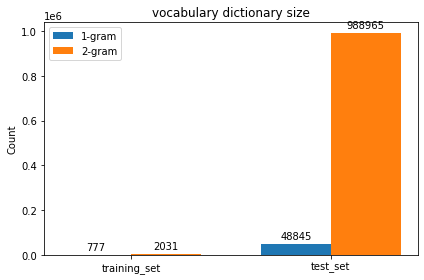

In [44]:
labels = ["training_set","test_set"]
one_gram = [len(train_gram), len(test_gram)]
two_gram = [len(train_two_gram), len(test_two_gram)]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, one_gram, width, label='1-gram')
rects2 = ax.bar(x + width/2, two_gram, width, label='2-gram')
ax.set_title('vocabulary dictionary size')
ax.set_ylabel('Count')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


autolabel(rects1)
autolabel(rects2)
fig.tight_layout()

plt.show()

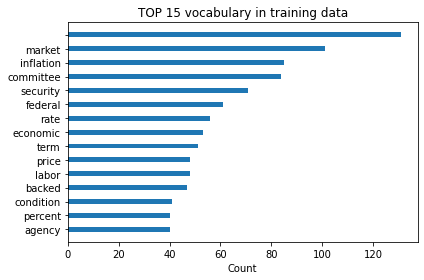

In [45]:
labels = list(train_gram)[:15]
freq = list(train_gram.values())[:15]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.barh(x, freq, width)
ax.set_title('TOP 15 vocabulary in training data')
ax.set_xlabel('Count')
ax.set_yticks(x)
ax.invert_yaxis() 
ax.set_yticklabels(labels)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, rect.get_y() + rect.get_height()/2.,
                '%.2f' % width,
                ha='center', va='center', color='white')

fig.tight_layout()
plt.show()

['policy', 'rate', 'financial', 'bank', 'market', 'federal', 'inflation', 'economic', 'risk', 'reserve', 'monetary', 'would', 'economy', 'year', 'percent']


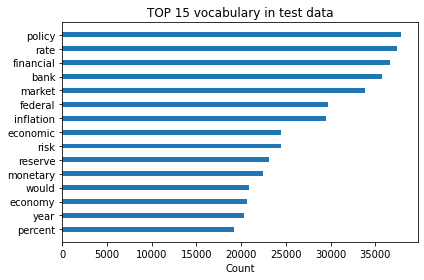

In [46]:
labels = []
freq = []
for i in range(len(list(test_gram))):
  if len(labels) >=15:
    break
  if not list(test_gram)[i] in stopwords.words('english') and  list(test_gram)[i] != '' and  list(test_gram)[i] != 'ha':
    labels.append(list(test_gram)[i])
    freq.append(list(test_gram.values())[i])
print(labels)
# labels = list(test_gram)[re]
# freq = list(test_gram.values())[re]
x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars
fig, ax = plt.subplots()
rects1 = ax.barh(x,freq, width)
ax.set_title('TOP 15 vocabulary in test data')
ax.set_xlabel('Count')
ax.set_yticks(x)
ax.invert_yaxis() 
ax.set_yticklabels(labels)
def autolabel(rects):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate('{}'.format(height),
                    xy=(rect.get_() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 points vertical offset
                    textcoords="offset points",
                    ha='center', va='bottom')


fig.tight_layout()
plt.show()